# Wait Wait, Don't Analyze Me!

![NPR logo](https://media.npr.org/branding/programs/wait-wait-dont-tell-me/branding_main-c5920a167d6a5d445ce86fac30b90454223b6b57.png "One nerd's attempt to learn everything there is to know about NPR's greatest quiz show.")


# Introduction
[Wait Wait, Don't Tell Me!](https://www.npr.org/programs/wait-wait-dont-tell-me/) is NPR's longest-running news quiz show. Contestents call in to answer questions about the week's news, and a rotating cast of three panelists make jokes and parody newsworthy (and not-so-newsworthy) current events. Listening to "Wait wait" has been a highlight of my week since I was a kid, and it remains one of NPR's most popular segments. So what better way to show my appreciation than to take it apart and see what makes it tick?

For this project, I have pulled text transcripts of each episode of "Wait, Wait", storing them as a MySQL library. I have two goals:
1. Understand and predict jokes in the program.
2. Create a "Wait wait" transcript generator, so that I don't have to wait a whole week between episodes!

In this section, I will create a transcript generator.

# Table of Contents

* Data Processing
    * 0.1 [Loading data](#data-loading)
    * 0.2 [Example transcript](#data-example)
    * 0.3 [Encoding transcripts](#data-encoding)
    * 0.4 [Building a training set](#data-train)
* RNN Modeling
    * 1.1 [Model Architecture](#model-initialize)
    * 1.2 [Model training]()
* Markov Model
    * 2.1 [Markov Chain](#markov)

# Section 0: Initial data processing

## 0.1 Loading the data <a name="loading"></a>
Before I can analyze the data, I must first load it and process it. To accomplish this, I wrote a simple function to load in text files containing the transcripts.

In [1]:
# Importing the libraries I'll be using
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import mysql.connector
import re
from sklearn.preprocessing import QuantileTransformer
import time
import matplotlib.cm as cm

%matplotlib inline

# change the default font size in figures to be larger
font = {'size'   : 15}
plt.rc('font', **font)

In [2]:
# connect to the database of wait wait don't tell me transcripts
cnx = mysql.connector.connect(database='wait_wait',
                              user='root')

In [3]:
# function to pull some transcripts from the database
def pull_transcript(n=5):
    # instantiate a cursor to select data from the database
    curs = cnx.cursor()
    curs.execute(f'select * from transcripts limit {n}')
    
    # pull the data and convert to a pandas dataframe
    df = pd.DataFrame(data = np.array(curs.fetchmany(n)),columns=curs.column_names)
    df = df.set_index('id')
    
    # close the cursor
    curs.close()
    return df

Let's go ahead and pull all of the transcripts from the database - this dataset happens to be small enough that I can load it all at once.

I also divide the transcripts randomly into testing, training, and validation sets. This will ensure that when I perform analyses, I don't build models that over-fit the data.

In [4]:
num_transcripts = 4131
transcript_df = pull_transcript(n=num_transcripts)

# split the tables into testing and training sets, so that we don't over-fit. 
np.random.seed(42) # Ensures that the split is the same each round
transcript_df['train'] = np.random.rand(num_transcripts)>.2
transcript_df['test'] = transcript_df['train']==False

# Further separate the training dataset into a training and validation set
transcript_df['val'] = (np.random.rand(num_transcripts)>.8) & (transcript_df['train'])

# ensure that the training and validation sets don't overlap
transcript_df['train'] = transcript_df['train'] & (transcript_df['val']==False)

In [5]:
transcript_df.head(10)

,episode_id,aired_at,url,segment,transcript,train,test,val
id,,,,,,,,
1,1,2019-05-04,https://www.npr.org/templates/transcript/trans...,who,\n \n \n \n\n BILL KURTIS: Fro...,True,False,False
2,1,2019-05-04,https://www.npr.org/templates/transcript/trans...,panel,"\n \n \n \n\n PETER SAGAL, HOS...",True,False,False
3,1,2019-05-04,https://www.npr.org/templates/transcript/trans...,bluff,\n \n \n \n\n BILL KURTIS: Fro...,True,False,False
4,1,2019-05-04,https://www.npr.org/templates/transcript/trans...,job,"\n \n \n \n\n PETER SAGAL, HOS...",True,False,False
5,1,2019-05-04,https://www.npr.org/templates/transcript/trans...,panel,"\n \n \n \n\n PETER SAGAL, HOS...",False,True,False
6,1,2019-05-04,https://www.npr.org/templates/transcript/trans...,limerick,"\n \n \n \n\n PETER SAGAL, HOS...",False,True,False
7,1,2019-05-04,https://www.npr.org/templates/transcript/trans...,lightning,"\n \n \n \n\n PETER SAGAL, HOS...",False,True,False
8,1,2019-05-04,https://www.npr.org/templates/transcript/trans...,predictions,"\n \n \n \n\n PETER SAGAL, HOS...",True,False,False
9,2,2019-04-27,https://www.npr.org/templates/transcript/trans...,who,\n \n \n \n\n BILL KURTIS: Fro...,True,False,False


In [6]:
# For simplicity, I'll set all letters to lower-case
transcript_df.loc[:,'transcript'] = transcript_df.loc[:,'transcript'].str.lower()

## 0.2 Example transcript<a name="data-example"></a>

To understand the data, it helps to first see what the raw data looks like. Let's print a little bit of the transcript from the first dataset.

In [7]:
print(transcript_df.loc[1,'transcript'][:500])


    
        
    

    bill kurtis: from npr and wbez chicago, this is wait wait... don't tell me, the npr news quiz. hey, arthur miller - step into this cruci-bill (ph).
    (laughter)
    kurtis: i'm bill kurtis. and here's your host at the chase bank auditorium in downtown chicago, peter sagal.
    peter sagal, host: 
    thank you, bill. thank you, everybody.
    (cheering)
    sagal: thank you so much. we have a very interesting show for you today. later on, we're going to be talking to m


In [8]:
transcript_df.loc[1,'transcript'][:1000]

"\n    \n        \n    \n\n    bill kurtis: from npr and wbez chicago, this is wait wait... don't tell me, the npr news quiz. hey, arthur miller - step into this cruci-bill (ph).\n    (laughter)\n    kurtis: i'm bill kurtis. and here's your host at the chase bank auditorium in downtown chicago, peter sagal.\n    peter sagal, host: \n    thank you, bill. thank you, everybody.\n    (cheering)\n    sagal: thank you so much. we have a very interesting show for you today. later on, we're going to be talking to microsoft co-founder steve ballmer. he is, we believe, the richest guest we've ever had. but, of course, your true wealth is measured in your friends. and this just in - he has more friends, too.\n    (laughter)\n    sagal: but first, as many of you know, the npr podcast feeds got all screwed up last week. people who tried to download our show got, for example, how i built this instead, for which i apologize. and the people who wanted how i built this got us, for which i apologize eve

Initially, we can note a number of features. First, audience responses are noted with the '(LAUGHTER)' marker and '(APPLAUSE)' marker. This will prove very useful, as we have an automatic metric for "funniness" of the preceding text. 

Speakers' names are in all caps, followed by a colon. Speakers are also separated by a line break and a tab, which could potentially be used to segment the text into phrases by various people. 

## 0.3 Encoding the text <a name='data-encoding'></a>



I will be building a letter-based generator for now, so I want a way to encode both letters and punctuation as integers (eventually, to be transferred into a one-hot encoding scheme for transferring to the model).

In [9]:
from sklearn.preprocessing import OneHotEncoder

In [10]:
all_tokens = set(transcript_df.loc[transcript_df.train,'transcript'].str.cat())
print(f'The dataset includes {len(all_tokens)} unique tokens')

The dataset includes 77 unique tokens


In [11]:
# Make a dictionary converting letters/punctuation to integers
conversion_dict = {}
for i, token in enumerate(all_tokens):
    conversion_dict[token] = i
    
# Make a second dictionary to go in the other direction
reversion_dict = dict( (v,k) for k, v in conversion_dict.items() )

In [12]:
# simple function to encode transcript
def encode_transcript(transcript):
    return [conversion_dict.get(n,len(all_tokens)) for n in transcript]
def decode_transcript(transcript):
    return [reversion_dict.get(n,len(all_tokens)) for n in transcript]

In [13]:
# Encode each of the transcripts by converting letters and punctuation to integers
transcript_df['encoded'] = transcript_df.loc[:,'transcript'].apply(encode_transcript)

In [14]:
transcript_df.head()

,episode_id,aired_at,url,segment,transcript,train,test,val,encoded
id,,,,,,,,,
1,1,2019-05-04,https://www.npr.org/templates/transcript/trans...,who,\n \n \n \n\n bill kurtis: fro...,True,False,False,"[44, 1, 1, 1, 1, 44, 1, 1, 1, 1, 1, 1, 1, 1, 4..."
2,1,2019-05-04,https://www.npr.org/templates/transcript/trans...,panel,"\n \n \n \n\n peter sagal, hos...",True,False,False,"[44, 1, 1, 1, 1, 44, 1, 1, 1, 1, 1, 1, 1, 1, 4..."
3,1,2019-05-04,https://www.npr.org/templates/transcript/trans...,bluff,\n \n \n \n\n bill kurtis: fro...,True,False,False,"[44, 1, 1, 1, 1, 44, 1, 1, 1, 1, 1, 1, 1, 1, 4..."
4,1,2019-05-04,https://www.npr.org/templates/transcript/trans...,job,"\n \n \n \n\n peter sagal, hos...",True,False,False,"[44, 1, 1, 1, 1, 44, 1, 1, 1, 1, 1, 1, 1, 1, 4..."
5,1,2019-05-04,https://www.npr.org/templates/transcript/trans...,panel,"\n \n \n \n\n peter sagal, hos...",False,True,False,"[44, 1, 1, 1, 1, 44, 1, 1, 1, 1, 1, 1, 1, 1, 4..."


In [15]:
# Generate a one-hot encoder to finally yield data in a one-hot version
onehotencoder = OneHotEncoder(categories='auto',sparse=False)
onehotencoder.fit(np.concatenate(transcript_df.encoded.values).reshape(-1,1))

OneHotEncoder(categorical_features=None, categories='auto', drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=False)

In [16]:
# Define a function to apply the one hot scheme to the integer-encoded values
def one_hot_transcript(transcript):
    integer_transcript = np.array(encode_transcript(transcript)).reshape(-1,1)
    return onehotencoder.transform(integer_transcript)

In [17]:
# Convert the encoded transcript values to the one-hot encodings
transcript_df['encoded'] = transcript_df.loc[:,'transcript'].apply(one_hot_transcript)

## 0.4 Building a training set <a name='data-train'></a>

To build up the training set, we will be taking all of our training transcripts and breaking them up into pieces of a set size. The "x" values will be the set of encoded integers, and the "y" value will be the integer that immediately follows. The goal of the model will be to predict the next letter (or punctuation mark), given the previous letters.

In [18]:
# parameters
n_times = 50
n_components = len(all_tokens)+1
step_size = 50
batch_size = 32

In [19]:
def generate_model_data(transcript):
    # makes calculating size easier to pre-build the iterator
    iterator = range(0,transcript.shape[0]-step_size-n_times,step_size) 
    
    # calculate the size of data we will be generating
    n_examples = len(iterator)

    # initialize x and y values
    x = np.zeros([n_examples,n_times,n_components])
    y = np.zeros([n_examples,n_components])

    # fill in the values for each split
    for step,startpos in enumerate(iterator):
        x[step] = transcript[startpos:startpos+n_times,:]
        y[step] = transcript[startpos+n_times,:]
    
    # return x and y
    return x,y

In [20]:
# For each element of the training transcript set, generate training data
def combine_model_data(transcript_df):
    x = list()
    y = list()
    for i,transcript in enumerate(transcript_df.encoded):
        x_,y_ = generate_model_data(transcript)
        x.append(x_)
        y.append(y_)

        # report progress
        if i%50==0:
            print(i)
    
    # combine all sets into arrays
    x = np.concatenate(x,axis=0)
    y = np.concatenate(y,axis=0)
        
    return x,y

In [21]:
# keeping things small for now, to ensure my code base works before going in with everything
# x_train,y_train = combine_model_data(transcript_df.loc[:500,:])
x_val,y_val     = combine_model_data(transcript_df.loc[1000:1200,  :])
# x_test,y_test   = combine_model_data(transcript_df.loc[120:140, :])

0
50
100
150
200


## 0.5 Data Generator
This is a different way of making the data. Doing the massive conversion of transcript to one-hot encoding is pretty memory-intensive. One way to improve that is to only process some of the data at a time, using a generator. This could also enable me to add some additional randomization into my process, so I'm going to play around with it. This code is closely based on the tutorial here: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

In [40]:
import keras
class DataGenerator(keras.utils.Sequence):
    # Generates data for Keras
    def __init__(self, df, batch_size=32,n_times=n_times,n_components=n_components,shuffle=True):
        # Initialization
        self.batch_size = batch_size
        self.df = df.encoded
        self.indices = np.copy(self.df.index.values)
        self.dim = (batch_size,n_times,n_components)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        # Denotes the number of batches per epoch
        return len(self.df.index.values)

    def __getitem__(self, index):

        # Generate data
        X, y = self.__data_generation(self.indices[index])

        return X, y

#     def on_epoch_end(self):
#         #'Updates indexes after each epoch'
#         self.indices = self.df.index.values
#         if self.shuffle == True:
#             np.random.shuffle(self.indices)

    def __data_generation(self, transcript_num):
        #'Generates data containing batch_size samples' 
        # Initialization
        X = np.empty(self.dim)
        y = np.empty((self.batch_size,self.dim[-1]), dtype=int)

        # Pull batch_size random samples from the specified transcript
        indices = np.random.randint(low=0,
                                    high=self.df[transcript_num].shape[0]-101,
                                    size=self.batch_size)
        
        # for each start position, pull a sequence of 100 chars for X, and the 101'st char for y
        for i, startpos in enumerate(indices):
            # Store sample
            X[i,] = self.df[transcript_num][i:i+100,:]

            # Store class
            y[i] = self.df[transcript_num][i+100,:]

        return X, y

In [224]:
train_gen = DataGenerator(transcript_df.loc[transcript_df.train,:],shuffle=True)
val_gen = DataGenerator(transcript_df.loc[transcript_df.val,:],shuffle=True)

# 1 Building and Training the model

## 1.0 Generate transcript function
First, specify a function that, given a model and a sample of text, will generate the next text for the transcript. We'll run this function occasionally in order to visualize how our model learning is progressing.

In [225]:
def Predict_transcript(sample,chars_to_generate=50):
    sample = sample.reshape(1,sample.shape[0],sample.shape[1])
    
    # initialize the phrase
    predicted_phrase = np.concatenate((sample,np.zeros((1,chars_to_generate,n_components))),axis=1)

    for char in range(n_times,n_times+chars_to_generate):
        # calculate the probability distribution
        probability = model.predict(sample).squeeze()

        # guess the next character and add it to our prediction
        guess = np.random.choice(a=n_components,p=probability)
        predicted_phrase[0,char,guess] = 1

        # feed the results into the next step of the model
        sample = predicted_phrase[:,(char+1-n_times):char+1,:]

    # Convert to text
    predicted_phrase = ''.join(decode_transcript(np.argmax(predicted_phrase,axis=-1).squeeze()))
    
    # Print result
    print(predicted_phrase)
    
    # output the phrase
    return predicted_phrase
    

## 1.0 Specifying model architecture <a name='model-initialize'></a>

I'm going to use a recurrent neural network (GRU) to generate my text. There are other systems I would also like to play with in the future (e.g. Markov models, transformer network), but this will make a good start.

In [226]:
# Sequential models are pretty simple, I'll start there.
from keras.models import Model
from keras.layers import GRU,Dense,Bidirectional,Input,Add,Dropout,SpatialDropout1D
from keras.callbacks import Callback

In [227]:
# parameter setting
n_units = 256 # size of RNN layers

# helper function to add in a middle GRU layer and sum the outputs+inputs to that layer
def Add_GRU_layer(inp,n_units):
    mid = Bidirectional(GRU(n_units,activation='tanh',input_shape=(n_times,n_components),return_sequences=True))(inp)
    mid = SpatialDropout1D(rate=.25)(mid)
    final = Add()([inp,mid])
    return final

## Model layer definitions start here
x_in = Input(shape=(None,n_components))

# GRU layers
x = Bidirectional(GRU(n_units,activation='tanh',input_shape=(n_times,n_components),return_sequences=True))(x_in)

# middle layers, with skip-gram combinations
for mid_layer in range(1):
    x = Add_GRU_layer(x,n_units)

# final layer, no returning sequences
x = Bidirectional(GRU(256,activation='tanh',input_shape=(n_times,n_components),return_sequences=False))(x)


dense_out = Dense(n_components,activation='softmax')(x)

model = Model(inputs=[x_in],outputs=[dense_out])
model.compile(loss='categorical_crossentropy',optimizer='adam')

In [228]:
# Generate a model summary to visualize the layers and model size
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, None, 78)     0                                            
__________________________________________________________________________________________________
bidirectional_70 (Bidirectional (None, None, 512)    514560      input_17[0][0]                   
__________________________________________________________________________________________________
bidirectional_71 (Bidirectional (None, None, 512)    1181184     bidirectional_70[0][0]           
__________________________________________________________________________________________________
spatial_dropout1d_5 (SpatialDro (None, None, 512)    0           bidirectional_71[0][0]           
__________________________________________________________________________________________________
add_40 (Ad

In [229]:
# callback to generate an example transcript prediction each time
class generator_callback(Callback):
    
    def on_epoch_end(self,epoch=0,logs={}):
        Predict_transcript(x_val[100]);

Epoch 1/10
82/82 [==============================] - 73s 889ms/step - loss: 0.6167
Epoch 2/10
82/82 [==============================] - 73s 892ms/step - loss: 0.8505
Epoch 3/10
82/82 [==============================] - 72s 879ms/step - loss: 0.8817
Epoch 4/10
82/82 [==============================] - 70s 859ms/step - loss: 0.8362
Epoch 5/10
82/82 [==============================] - 76s 929ms/step - loss: 0.6920
Epoch 6/10
82/82 [==============================] - 78s 954ms/step - loss: 0.7318
Epoch 7/10
82/82 [==============================] - 77s 938ms/step - loss: 0.7763
Epoch 8/10
82/82 [==============================] - 74s 896ms/step - loss: 0.7679
Epoch 9/10
82/82 [==============================] - 72s 876ms/step - loss: 0.6755
Epoch 10/10
82/82 [==============================] - 74s 899ms/step - loss: 0.6784


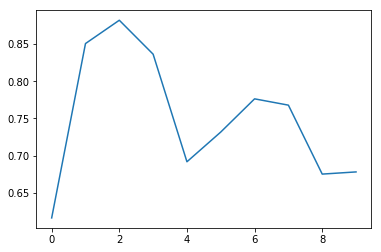

In [232]:
# Train the model
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',patience=8)
progress_reporter = generator_callback()
history = model.fit_generator(train_gen,
                              epochs=10,
                              steps_per_epoch=82)
plt.plot(history.history['loss'])

In [ ]:
model.score_generator()

In [233]:
Predict_transcript(x_val[100],chars_to_generate=50);

 a speeding problem. what to do? beg police to issue tickets? install speed bumps? or you could just this whas ding? e cia abaut sthings sirging afim 


# 2.0 Markov Chain <a name="markov"></a>
As a control, let's build a much simpler system, called a "Markov chain." This system simply calculates the probability of a next character, given the previous characters (how many previous characters is a selectable parameter). It then generates text by sampling this probability matrix. We can compare the performance of the Markov chain with the performance of the RNN.

This code initialized with the tutorial provided here: https://eli.thegreenplace.net/2018/elegant-python-code-for-a-markov-chain-text-generator/

In [213]:
from collections import defaultdict, Counter
import random

# This is the length of the "state" the current character is predicted from.
STATE_LEN = 15

In [214]:
# join all transcripts together
data = transcript_df.loc[:,'transcript'].str.cat()


In [215]:
# initialize model
markovmodel = defaultdict(Counter)
print('Learning model...')
for i in range(len(data) - STATE_LEN):
    state = data[i:i + STATE_LEN]
    nxt = data[i + STATE_LEN]
    markovmodel[state][nxt] += 1
    if i%10000000 ==0:
        print(f'{i}/{len(data)}')

Learning model...
0/31012208
10000000/31012208
20000000/31012208
30000000/31012208


In [234]:
print('Sampling...')
state = random.choice(list(markovmodel))
out = state
for i in range(10000):
    out += random.choices(list(markovmodel[state]), markovmodel[state].values())[0]
    state = out[-STATE_LEN:]
print(out)

Sampling...
e me a break people, do i need to even hear any of the other sex. it's a great, much needed resource, except when you get your car, you walk away.
    (applause)
    sagal: i don't remember anything?
    kluwe: yeah, actually we do most of our playing during the interrogation after they told her they would spend a head-banging night in jail.
    pesca: yeah, could you tap dance?
    foster: pretty good, peter. she got two right...
    clayton: a company in blank.
    bodett: all right, a local.
    (applause)
    poundstone: you know, i don't - i want - if anyone is going to do what?
    o'rourke: tax.
    sagal: right.
    (soundbite of laughter)
    sagal: this may be too personal but do you have sex with animals?
    sagal: no. after snakes were reported emerging from a chia lawn. you can pick the one you think is the real story of a deal discovered in the midterm elections by getting as far away from what?
    luke burbank: who told her about the identities of his birth